# Variational AutoEncoder (VAE)**

In [3]:
!python --version

Python 3.10.14


In [2]:
#!pip install tensorflow==2.8.0
!pip install keras==3.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 4.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
import numpy as np
from ipywidgets import interact
#from keras import backend as K
import tensorflow.keras.backend as K
import seaborn as sns
import matplotlib.pyplot as plt
print ('import completed')

import completed


In [4]:
import keras 
print(keras.__version__)
print(tf.__version__)

3.0.0
2.16.1


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 784)
(10000, 784)


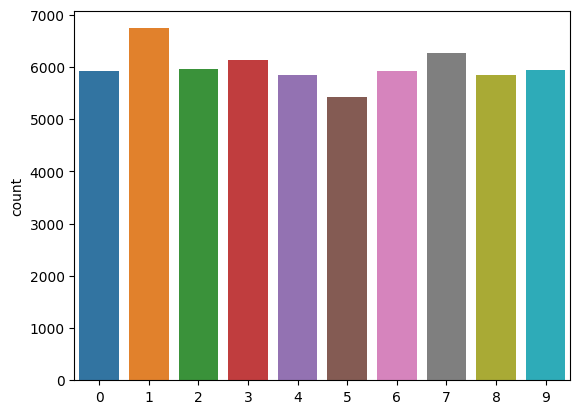

In [5]:
(x_train, x_train_label), (x_test, x_test_label) = mnist.load_data()
#(x_train, x_train_label), (x_test, x_test_label) = fashion_mnist.load_data() # In case you want to try fashion mnist

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Show the dimensions
print(x_train.shape)
print(x_test.shape)

# verify the labels are distributed evenly
g = sns.countplot(x=x_train_label)

In [ ]:
K.clear_session()
# This are the dimensions of the original input, the intermediate layer and latent layer
original_dim = 784
intermediate_dim = 256
latent_dim = 2 # 

# Variational autoencoder model
input_img = keras.Input(shape=(original_dim,))
encoded = layers.Dense(intermediate_dim, activation='relu')(input_img)
x_mean = layers.Dense(latent_dim)(encoded)
x_log_var = layers.Dense(latent_dim)(encoded) # implementation choice to encode the log variance i.s.o. the standard deviation

def sampling(args):
    # reparameterization trick
    # instead of sampling from Q(z|x), sample eps = N(0,I)
    # then x = x_mean + x_sigma*eps= x_mean + sqrt(e^(x_log_var))*eps = x_mean + e^(0.5 * x_log_var)*eps
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(x_mean)[0], latent_dim), mean=0.,
                              stddev=1.0)
    return x_mean + K.exp(0.5 * x_log_var) * epsilon # (e^a)^b=e^ab
x = layers.Lambda(sampling, output_shape=(latent_dim,))([x_mean, x_log_var])
# at this point the representation has dimension: latent_dim 

decoded = layers.Dense(intermediate_dim, activation='relu')(x)
decoded = layers.Dense(original_dim, activation='sigmoid')(decoded)
vae = keras.Model(input_img, decoded, name='vae')
#print (vae.summary())

# Create the loss function and compile the model
# The loss function as defined by paper Kingma
reconstruction_loss = original_dim * keras.metrics.binary_crossentropy(input_img, decoded) 
kl_loss =  -0.5 * K.sum(1 + x_log_var - K.square(x_mean) -K.exp(x_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Next the encoder part and decoder model, in order to inspect the inner representation, referencing the autoencode layers (the 3 models share there weights)
# This part can be ommitted in case you don't want to use the inner latent representation 

# encoder model (first part of the variotional autoencoder) 
encoder = keras.Model(input_img, [x_mean, x_log_var, x], name='encoder')
#print (encoder.summary())

# decoder model (second part of the autoencoder) to be able to generate an image from an inner representation
encoded_input = keras.Input(shape=(latent_dim,))
decoder_layer = vae.layers[-2](encoded_input) # Retrieve the last layers of the autoencoder model
decoder_layer = vae.layers[-1](decoder_layer)
decoder = keras.Model(encoded_input, decoder_layer, name='decoder')
#print (decoder.summary())

In [ ]:
keras.utils.plot_model(vae, to_file='model.png', show_shapes=True)

In [ ]:
keras.utils.plot_model(encoder, to_file='model.png', show_shapes=True)

In [ ]:
keras.utils.plot_model(decoder, to_file='model.png', show_shapes=True)

In [ ]:
vae.fit(x_train,None,
        shuffle=True,
        epochs=50,
        batch_size=256,
        validation_data=(x_test, None))

In [ ]:
# Encode and decode some digits, show the inner latent variable, inner representation

encoded_imgs = encoder.predict(x_test)[2]
decoded_imgs = decoder.predict(encoded_imgs)
#decoded_imgs = vae.predict(x_test)

#Show results: original, encode inner latent representation, decoded image
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.set_xlabel("{}".format(np.array2string(encoded_imgs[i],max_line_width=10)))
    plt.gray()
    ax.get_yaxis().set_visible(False)
    #ax.get_xaxis().set_visible(False)
    ;
plt.show()

In [ ]:
# Showcase the inner hidden/latent space by plotting all the test images on the latent space
x_test_encoded = encoder.predict(x_test, batch_size=128)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=x_test_label, cmap='rainbow')
plt.colorbar()
plt.show()

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Ssample n points within [-3, 3] standard deviations
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.axis('off')
plt.show()

In [ ]:
@interact

def morph(x = 3, y=3):
    x_decoded = decoder.predict(np.array([[x, y]]))
    plt.imshow(x_decoded.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return plt.figure()